In [1]:
import glob
import re
import os
import sys
import kipoi
import numpy as np
import datetime
import warnings
import pandas as pd
import matplotlib.pyplot as plt
start = datetime.datetime.now()

old_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")
model = kipoi.get_model('DeepSEA/predict')
sys.stdout = old_stdout
batch_size=100
#sys.argv=[" ","5_158526788",5000,"gene_name",1,100,500000]
sys.argv=[" ","2_127864931",5000,"BIN1",1,100,500000]
sys.argv[2]=int(sys.argv[2])
sys.argv[4]=int(sys.argv[4])
sys.argv[5]=int(sys.argv[5])
sys.argv[6]=int(sys.argv[6])
#print(sys.argv[1])
with open("temp/"+sys.argv[1]+"/expression/"+sys.argv[1]+".tsv") as f:
    content = f.readlines()

content = [x.strip() for x in content]
content[0] = content[0].split()
content[1] = content[1].split()
answ=np.empty([sys.argv[2],445,919])
expr=np.empty([445])
i=0


In [2]:
for g in sorted(glob.glob("temp/"+sys.argv[1]+"/fa_output/out"+sys.argv[1]+"_*.fa.gz")):
    dl_kwargs = {'intervals_file': 'temp/'+sys.argv[1]+'/intervals/'+os.path.splitext(os.path.basename(g))[0], 'fasta_file': g, "num_chr_fasta": "False"}
    warnings.filterwarnings('ignore',category=FutureWarning)
    dl = model.default_dataloader(**dl_kwargs)
    #it = dl.batch_iter(batch_size=sys.argv[2])
    it = dl.batch_iter(batch_size=batch_size)
    for b in range(0,sys.argv[2],batch_size):
        batch = next(it)
        warnings.filterwarnings('default',category=FutureWarning)
        if (sys.argv[2]<=b+batch_size):
            answ[b:sys.argv[2],i,:]=model.predict_on_batch(batch['inputs'])
        else:
            answ[b:b+batch_size,i,:]=model.predict_on_batch(batch['inputs'])
    expr[i]=content[1][content[0].index(re.split('_|\.',g)[-3])]
    i+=1

In [3]:
corrrr=abs(np.corrcoef(answ.reshape(sys.argv[2]*445,919).transpose()))

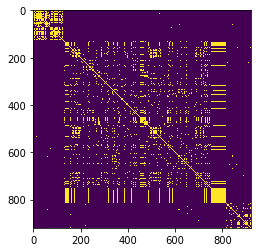

0.2590195600905862
5.186840784317301e-07
1.0
0.19972333271844547


In [13]:
plt.imshow(corrrr>0.7)
plt.show()
print(corrrr.mean())
print(corrrr.min())
print(corrrr.max())
print(np.median(corrrr))

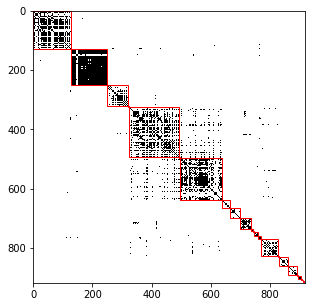

In [14]:
import networkx as nx
from matplotlib import pyplot, patches
import numpy as np

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(5, 5)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx-0.5, current_idx-0.5),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)


import numpy as np
from collections import defaultdict

import community

cutoff=0.7
G = nx.from_numpy_matrix(corrrr>cutoff)
# Run louvain community finding algorithm
louvain_community_dict = community.best_partition(G)

# Convert community assignmet dict into list of communities
louvain_comms = defaultdict(list)
for node_index, comm_id in louvain_community_dict.items():
    louvain_comms[comm_id].append(node_index)
louvain_comms = louvain_comms.values()

nodes_louvain_ordered = [node for comm in louvain_comms for node in comm]
draw_adjacency_matrix(G, nodes_louvain_ordered, [louvain_comms], ["red"])

In [14]:
from sklearn.covariance import GraphicalLasso
model = GraphicalLasso(max_iter=100)
#X = (n_samples = 445*5000, n_features=919) answ=np.empty([sys.argv[2],445,919])
#X = answ[1,:,:]
X = answ.reshape(sys.argv[2]*445,919)
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

KeyboardInterrupt: 

In [70]:
print(cov_.max())
np.fill_diagonal(cov_,0)
labs=pd.read_csv("deepsea_postprocessing/predictor.names",header = None).values.flatten()
cov_pd=pd.DataFrame(cov_, index=labs, columns=labs)

0.011741298530527257


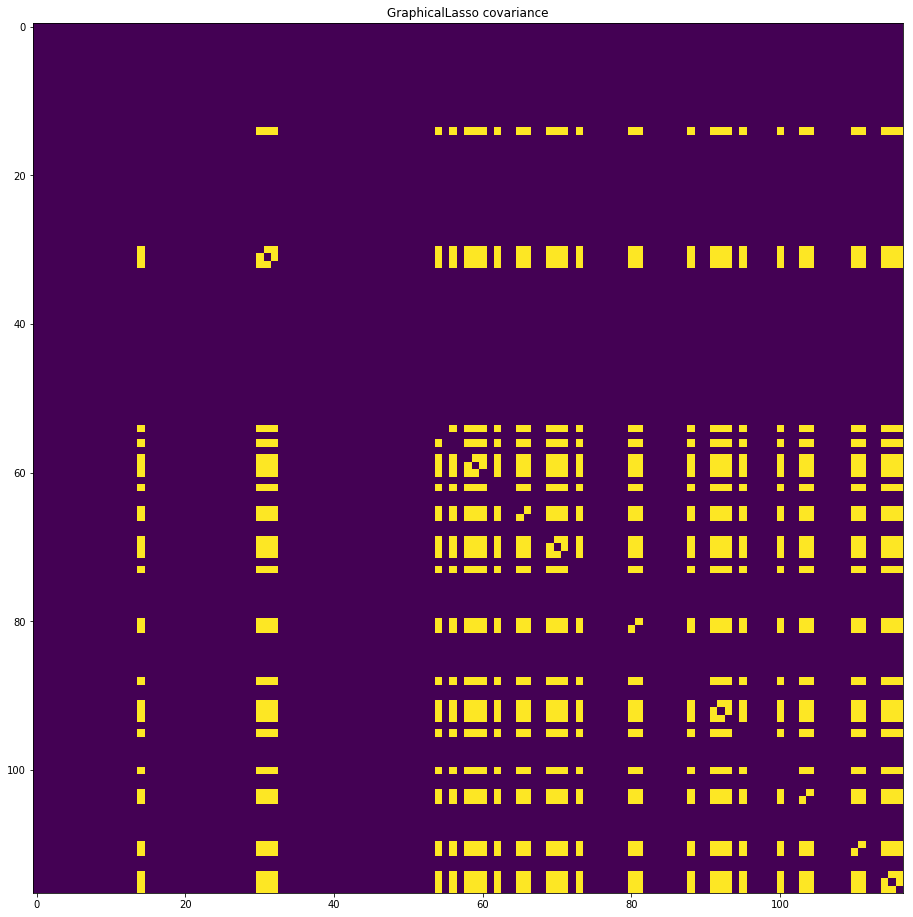

In [77]:
vmax = cov_.max()
plt.figure(figsize=(16, 16))
limit_min=800
limit_max=917
#plt.imshow(cov_pd, interpolation='nearest')#, vmin=0, vmax=vmax/100000,
plt.imshow(cov_[limit_min:limit_max,limit_min:limit_max]>0, interpolation='nearest')#, vmin=0, vmax=vmax/100000,
           #cmap=plt.cm.RdBu_r)
#print(labs)
#plt.axis(labs)
#plt.xlabel(labs)
#plt.xticks(())
#plt.yticks(())
plt.title('%s covariance' % "GraphicalLasso")
plt.show()

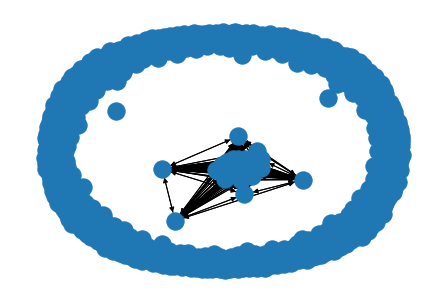

In [34]:
import networkx as nx
#input_data = cov_
G = nx.DiGraph(cov_)

nx.draw(G)

In [91]:
labels=(dict(enumerate(labs)))
for n, label in labels.items():
    (x, y) = pos[n]

NameError: name 'pos' is not defined

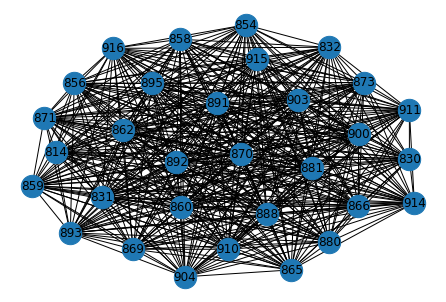

[814 830 831 832 854 856 858 859 860 862 865 866 869 870 871 873 880 881
 888 891 892 893 895 900 903 904 910 911 914 915 916]
['H1-hESC|H3K4me1|None' 'H1-hESC|H3K4me2|None' 'H1-hESC|H3K4me3|None'
 'Monocytes-CD14+RO01746|H2AZ|None' 'Monocytes-CD14+RO01746|H3K27me3|None'
 'Monocytes-CD14+RO01746|H3K4me1|None'
 'Monocytes-CD14+RO01746|H3K4me2|None'
 'Monocytes-CD14+RO01746|H3K4me3|None'
 'Monocytes-CD14+RO01746|H3K9ac|None' 'NH-A|H2AZ|None' 'NH-A|H3K27ac|None'
 'NH-A|H3K4me1|None' 'NH-A|H3K4me2|None' 'NH-A|H3K4me3|None'
 'NH-A|H3K9ac|None' 'NHDF-Ad|H3K4me1|None' 'NHDF-Ad|H3K4me2|None'
 'NHEK|H3K27ac|None' 'NHEK|H3K4me1|None' 'NHEK|H3K4me2|None'
 'NHEK|H3K4me3|None' 'NHEK|H3K9ac|None' 'NHLF|H3K27ac|None'
 'NHLF|H3K4me1|None' 'NHLF|H3K4me2|None' 'Osteoblasts|H2AZ|None'
 'Osteoblasts|H3K27ac|None' 'Osteoblasts|H3K4me1|None'
 'Osteoblasts|H3K4me2|None' 'Osteoblasts|H3K4me3|None' 'WI-38|CTCF|None']


In [106]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    #edges = zip(labs[rows.tolist()], labs[cols.tolist()])
    #print(labs[rows.tolist()])
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, with_labels=True)
    #nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
    plt.show()

show_graph_with_labels(cov_>0,dict(enumerate(labs)))

rows, cols = np.where((cov_>0) == 1)
print(np.unique(rows.tolist()))
print((np.unique(labs[rows.tolist()])))

In [5]:
precs = [('Empirical', linalg.inv(emp_cov)), ('Ledoit-Wolf', lw_prec_),
         ('GraphicalLasso', prec_), ('True', prec)]
vmax = .9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(np.ma.masked_equal(this_prec, 0),
               interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')


NameError: name 'linalg' is not defined